In [8]:
!pip3 install gensim
!pip3 install bs4
!pip3 install numpy

In [1]:
import re
import gensim
import nltk.data
import pandas as pd
import urllib.request
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import word2vec
from nltk.tokenize import sent_tokenize, RegexpTokenizer

from warnings import filterwarnings
filterwarnings("ignore")
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /home/egor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/egor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
!wget https://raw.githubusercontent.com/ancatmara/data-science-nlp/master/data/w2v/train/unlabeledTrainData.tsv

--2024-09-30 13:48:02--  https://raw.githubusercontent.com/ancatmara/data-science-nlp/master/data/w2v/train/unlabeledTrainData.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67281491 (64M) [text/plain]
Saving to: ‘unlabeledTrainData.tsv’

unlabeledTrainData. 100%[===================>]  64.16M  8.22MB/s    in 8.6s    

2024-09-30 13:48:15 (7.47 MB/s) - ‘unlabeledTrainData.tsv’ saved [67281491/67281491]



In [23]:
data = pd.read_csv("unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
data.head()

,id,review
0,"""9999_0""","""Watching Time Chasers, it obvious that it was..."
1,"""45057_0""","""I saw this film about 20 years ago and rememb..."
2,"""15561_0""","""Minor Spoilers<br /><br />In New York, Joan B..."
3,"""7161_0""","""I went to see this film with a great deal of ..."
4,"""43971_0""","""Yes, I agree with everyone on this site this ..."


In [24]:
len(data)

50000

In [26]:
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

In [27]:
def review_to_wordlist(review, remove_stopwords=False ):
    # убираем ссылки
    review_text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", review)
    # достаем сам текст
#     review_text = BeautifulSoup(review_text, "lxml").get_text()
    # оставляем только буквенные символы
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    words = review_text.lower().split()
    if remove_stopwords: # убираем стоп-слова
        stops = stopwords.words("english")
        words = [w for w in words if not w in stops]
    return(words)

def review_to_sentences(review, tokenizer, remove_stopwords=False):
    # разбиваем обзор на предложения
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    # применяем предыдущую функцию к каждому предложению
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, remove_stopwords))
    return sentences

In [30]:
from tqdm import tqdm

sentences = []

for s in tqdm(data["review"]):
    sentences += review_to_sentences(s, tokenizer)

100%|██████████| 50000/50000 [00:10<00:00, 4671.36it/s]


In [31]:
sentences[0]

['watching',
 'time',
 'chasers',
 'it',
 'obvious',
 'that',
 'it',
 'was',
 'made',
 'by',
 'a',
 'bunch',
 'of',
 'friends']

In [34]:
with open("clean_text.txt", "w") as file:
    for s in sentences:
        file.write(" ".join(s))
        file.write("\n")

Обучаем и сохраняем модель. 


Основные параметры:
* данные должны быть итерируемым объектом 
* size — размер вектора, 
* window — размер окна наблюдения,
* min_count — мин. частотность слова в корпусе,
* sg — используемый алгоритм обучения (0 — CBOW, 1 — Skip-gram),
* sample — порог для downsampling'a высокочастотных слов,
* workers — количество потоков,
* alpha — learning rate,
* iter — количество итераций,
* max_vocab_size — позволяет выставить ограничение по памяти при создании словаря (т.е. если ограничение превышается, то низкочастотные слова будут выбрасываться). Для сравнения: 10 млн слов = 1Гб RAM.

**NB!** Обратите внимание, что тренировка модели не включает препроцессинг! Это значит, что избавляться от пунктуации, приводить слова к нижнему регистру, лемматизировать их, проставлять частеречные теги придется до тренировки модели (если, конечно, это необходимо для вашей задачи). Т.е. в каком виде слова будут в исходном тексте, в таком они будут и в модели.

In [37]:
%time model = word2vec.Word2Vec(sentences=sentences, workers=4, vector_size=300, min_count=10, window=10, sample=0.001)

CPU times: user 2min 9s, sys: 404 ms, total: 2min 10s
Wall time: 34.9 s


In [40]:
len(model.wv)

28316

In [41]:
model.wv.most_similar(positive=["woman", "actor"], negative=["man"], topn=1)

[('actress', 0.7667942047119141)]

In [42]:
!wget https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Train.csv

--2024-09-30 14:25:10--  https://raw.githubusercontent.com/diptamath/covid_fake_news/main/data/Constraint_Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1253562 (1.2M) [text/plain]
Saving to: ‘Constraint_Train.csv’

Constraint_Train.cs 100%[===================>]   1.20M  2.42MB/s    in 0.5s    

2024-09-30 14:25:11 (2.42 MB/s) - ‘Constraint_Train.csv’ saved [1253562/1253562]



In [42]:
fake_news_df = pd.read_csv("Constraint_Train.csv")
fake_news_df.head() 

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


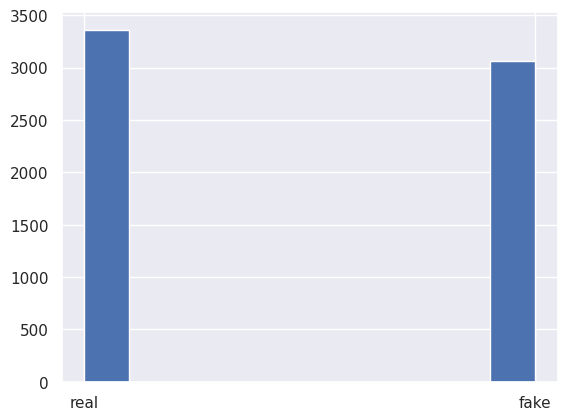

In [43]:
sns.set_theme()
fake_news_df["label"].hist()
plt.show()

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from nltk.tokenize import word_tokenize
from tqdm import tqdm

In [45]:
le = LabelEncoder()
le.fit(fake_news_df["label"])

LabelEncoder()

In [46]:
le.classes_
le.transform(["fake"]), le.transform(["real"])

(array([0]), array([1]))

In [47]:
fake_news_df["label"] = fake_news_df[["label"]].apply(le.transform)

In [48]:
fake_news_df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,1
1,2,States reported 1121 deaths a small rise from ...,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,5,Populous states can generate large case counts...,1


In [49]:
sentences = [word_tokenize(word.lower()) for word in tqdm(fake_news_df["tweet"])]

100%|██████████| 6420/6420 [00:00<00:00, 9417.21it/s]


In [50]:
vectorizer = word2vec.Word2Vec(
    sentences=sentences,
    window=5,
    workers=5, 
    vector_size=300,
    min_count=2
)

In [51]:
vectorizer.wv.most_similar("president")

[('trump', 0.9948027729988098),
 ('donald', 0.994584321975708),
 ('tweeted', 0.9941276907920837),
 ('says', 0.9860576391220093),
 ('downplayed', 0.9824424982070923),
 ('forged', 0.9807094931602478),
 ('beef', 0.9804186820983887),
 ('i', 0.9785881638526917),
 ('why', 0.9772324562072754),
 ('wasn', 0.9751392602920532)]

In [52]:
import numpy as np

In [53]:
def get_mean_embedding(sentence, vectorizer=vectorizer):
    res = np.zeros(300)
    count = 0

    words = word_tokenize(sentence)
    for w in words:
        if w in vectorizer.wv:
            res += vectorizer.wv[w]
            count += 1
    if count == 0:
        return np.zeros(300)
    return res / count

In [54]:
fake_news_df["embedding"] = fake_news_df["tweet"].apply(get_mean_embedding)
fake_news_df.head()

,id,tweet,label,embedding
0,1,The CDC currently reports 99031 deaths. In gen...,1,"[0.0695254763122648, 0.4410159645974636, 0.083..."
1,2,States reported 1121 deaths a small rise from ...,1,"[0.22237669659079984, 0.6362450374290347, 0.04..."
2,3,Politically Correct Woman (Almost) Uses Pandem...,0,"[0.027632566215470434, 0.49609348848462104, 0...."
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,1,"[0.08338028993761248, 0.6124424186089764, 0.08..."
4,5,Populous states can generate large case counts...,1,"[0.12566734658850526, 0.5904802969007781, 0.07..."


In [55]:
feature = [get_mean_embedding(x) for x in fake_news_df["tweet"]]

In [59]:
X_train, X_test, y_train, y_test = train_test_split(
    feature,
    fake_news_df["label"],
    test_size=0.33,
    random_state=42
)

In [60]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [61]:
y_pred = model.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1009
           1       0.84      0.84      0.84      1110

    accuracy                           0.83      2119
   macro avg       0.83      0.83      0.83      2119
weighted avg       0.83      0.83      0.83      2119

